## Reading in packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
import vaex as vx
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v5

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix

2.2.0
C:\Users\PC\AppData\Local\Temp\tmpxodji1dc\tensorboard_logs


In [3]:
os.listdir('../../../Desktop')

['Atom.lnk',
 'AU.txt',
 'CryptoExtraction',
 'desktop.ini',
 'exchange-codes.txt',
 'Git-2.27.0-64-bit.exe',
 'Google Drev.lnk',
 'Kristian',
 'Kristian.zip',
 'Mødrup.txt',
 'Pensionsinfo - vejledning.pdf',
 'SissePensionsInfo.pdf',
 'SisseSkat2019.pdf',
 'SupportAssistLauncher.exe',
 'taqquote_20200501.h5',
 'Vejledning til SKAT.pdf']

In [4]:
raw_file = h5py.File('../../../Desktop/'+'taqquote_20200501.h5','r')

In [5]:
raw_file.keys()

<KeysViewHDF5 ['QuoteIndex', 'Quotes']>

In [6]:
# df = vx.example()
# df = vx.open('../../../Desktop/'+'taqquote_20200501.h5')
# df = vx.from_dict(raw_file['QuoteIndex'])

In [16]:
raw_file['QuoteIndex']['ptr' in raw_file['QuoteIndex']]#0:50

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  """Entry point for launching an IPython kernel.


(b'A                ', 0, 277030)

In [19]:
[i for i in raw_file['QuoteIndex'] if 'PTR' in str(i)[-100:]]

[(b'PTR              ', 698336075, 44570)]

In [21]:
temp = pd.DataFrame(raw_file['Quotes'][698336075:698336075+44570])#[2627943:2627943+3096434])

In [9]:
def strList(ls):
    return list(map(lambda x: x.decode('utf-8'),ls))

In [22]:
temp[['utcsec','ex','bid','bidsize','ofr','ofrsize']]
temp['timestamp'] = pd.to_timedelta(temp.loc[:,'utcsec'])
# temp['date'] = pd.to_datetime('2020-05-01', format='%Y%m%d', errors='ignore')
temp['dtts'] = pd.Timestamp('2020-05-01')+temp.timestamp
temp.loc[:,'ex'] = strList(temp.ex)
# temp['dtts'] = temp.date+temp.timestamp

In [23]:
temp.head()

,utcsec,ex,bid,bidsize,ofr,ofrsize,mode,SequenceNumber,NationalBBOInd,FinraBBOInd,...,ShortSaleRestrictionIndicator,LuldBBOIndicator,SIPGeneratedMessageIdent,NationalBBOLuldIndicator,ParticipantTimestamp,FinraTimestamp,FinraQuoteIndicator,SecurityStatusIndicator,timestamp,dtts
0,14400041485373,P,0.0,0,46.67,2,b'R',48303,b'G',b' ',...,b'',b'',b'',b'',14400041330688,99,b'',b' ',04:00:00.041485,2020-05-01 04:00:00.041485373
1,14400041485373,P,0.0,0,42.00,3,b'R',48305,b'G',b' ',...,b'',b'',b'',b'',14400041331456,99,b'',b' ',04:00:00.041485,2020-05-01 04:00:00.041485373
2,14400041485373,P,0.0,0,40.00,1,b'R',48306,b'G',b' ',...,b'',b'',b'',b'',14400041331968,99,b'',b' ',04:00:00.041485,2020-05-01 04:00:00.041485373
3,14400041513142,P,12.0,2,40.00,1,b'R',48401,b'G',b' ',...,b'',b'',b'',b'',14400041403392,99,b'',b' ',04:00:00.041513,2020-05-01 04:00:00.041513142
4,14400041513142,P,20.0,1,40.00,1,b'R',48402,b'G',b' ',...,b'',b'',b'',b'',14400041403904,99,b'',b' ',04:00:00.041513,2020-05-01 04:00:00.041513142


In [24]:
temp['dtts'] = pd.Timestamp('2020-05-01')+temp.timestamp

In [26]:
temp.ex.unique()

array(['P', 'Y', 'K', 'T', 'Z', 'J', 'M', 'B', 'X', 'N', 'C', 'V', 'A'],
      dtype=object)

In [30]:
## 6848 - 9771
temp_Q = temp[temp.ex=='T'].reset_index(drop=True)
temp_Q[(temp_Q.dtts.dt.hour==9)&(temp_Q.dtts.dt.minute==30)]

,utcsec,ex,bid,bidsize,ofr,ofrsize,mode,SequenceNumber,NationalBBOInd,FinraBBOInd,...,ShortSaleRestrictionIndicator,LuldBBOIndicator,SIPGeneratedMessageIdent,NationalBBOLuldIndicator,ParticipantTimestamp,FinraTimestamp,FinraQuoteIndicator,SecurityStatusIndicator,timestamp,dtts
16,34201607230546,T,33.68,5,35.50,3,b'R',29014001,b'A',b' ',...,b'',b'',b'',b'A',34201606709397,99,b'',b' ',09:30:01.607230,2020-05-01 09:30:01.607230546
17,34212580175463,T,33.97,3,35.50,3,b'R',32689501,b'A',b' ',...,b'',b'',b'',b'A',34212579688138,99,b'',b' ',09:30:12.580175,2020-05-01 09:30:12.580175463
18,34236033448353,T,33.97,3,35.47,1,b'R',36628801,b'A',b' ',...,b'',b'',b'',b'A',34236032947122,99,b'',b' ',09:30:36.033448,2020-05-01 09:30:36.033448353
19,34255233419994,T,33.97,3,35.50,3,b'R',39373501,b'A',b' ',...,b'',b'',b'',b'A',34255232930280,99,b'',b' ',09:30:55.233419,2020-05-01 09:30:55.233419994
20,34255442125883,T,33.97,3,35.47,1,b'R',39403401,b'A',b' ',...,b'',b'',b'',b'A',34255441599490,99,b'',b' ',09:30:55.442125,2020-05-01 09:30:55.442125883


In [31]:
#9771
oneMinute = temp_Q.loc[0:100][['dtts','utcsec','ex','bid','bidsize','ofr','ofrsize']].copy(deep=True)
oneMinute['mid_price'] = (oneMinute.bid+oneMinute.ofr)/2
oneMinute.index = np.arange(0,60,60/oneMinute.shape[0])
# oneMinute = oneminute

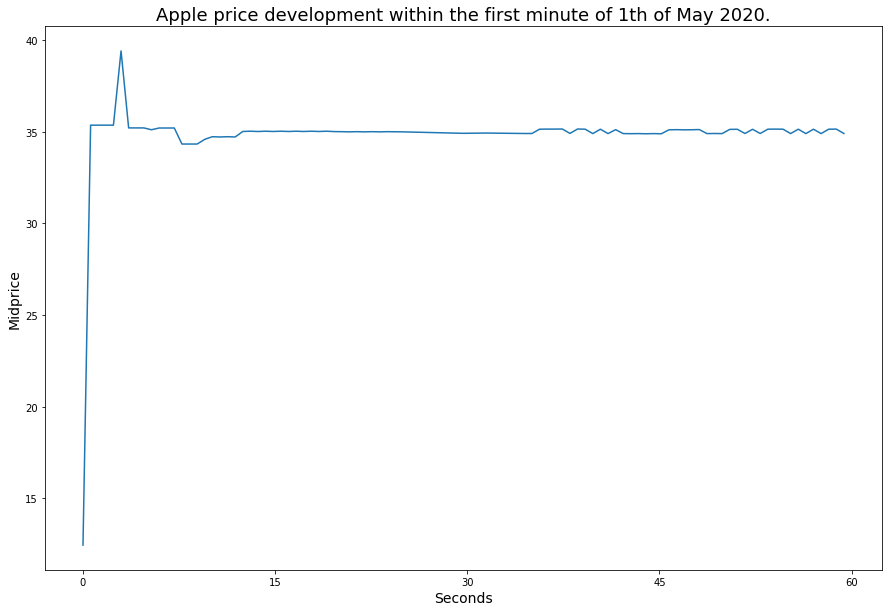

In [32]:
oneMinute.mid_price.plot(figsize=(15,10))
# plt.vertical
plt.xticks(np.arange(0,75,15))
plt.xlabel('Seconds', fontsize=14)
plt.ylabel('Midprice',fontsize=14)
plt.title('Apple price development within the first minute of 1th of May 2020.',fontsize=18)

# plt.savefig('..\..\AppleDevelopment_v2.png',bbox_inches='tight')
plt.show()

In [20]:
# 
returns = (oneMinute.mid_price.values[1:]/oneMinute.mid_price.values[0:-1]-1)*100

In [21]:
returns

array([ 0.03668122, -0.03666777,  0.03668122, ..., -0.01196234,
        0.01196377, -0.01367124])

In [35]:
import seaborn as sns
sns.set_style(style="darkgrid")

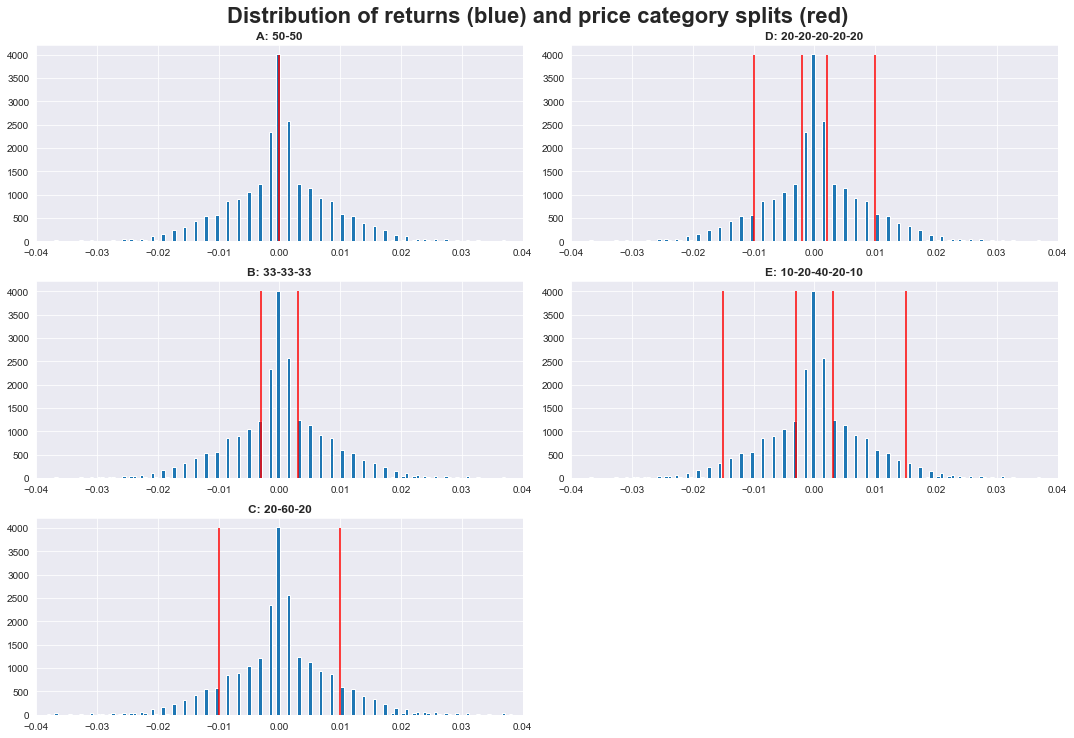

In [36]:

fig, ax = plt.subplots(3,2,figsize=(15,10))

ax[0,0].hist(returns,bins=200)
ax[0,0].vlines(0,0,4000,color = 'r')
ax[0,0].set_title('A: 50-50'
                  ,fontweight='bold')
ax[0,0].set_xlim(-0.04,0.04)

ax[1,0].hist(returns,bins=200)
ax[1,0].vlines(-0.003,0,4000,color = 'r')
ax[1,0].vlines(0.003,0,4000,color = 'r')
ax[1,0].set_title('B: 33-33-33'
                  ,fontweight='bold')
ax[1,0].set_xlim(-0.04,0.04)

ax[2,0].hist(returns,bins=200)
ax[2,0].vlines(-0.01,0,4000,color = 'r')
ax[2,0].vlines(0.01,0,4000,color = 'r')
ax[2,0].set_title('C: 20-60-20'
                  ,fontweight='bold')
ax[2,0].set_xlim(-0.04,0.04)

ax[0,1].hist(returns,bins=200)
ax[0,1].vlines(-0.002,0,4000,color = 'r')
ax[0,1].vlines(0.002,0,4000,color = 'r')
ax[0,1].vlines(-0.01,0,4000,color = 'r')
ax[0,1].vlines(0.01,0,4000,color = 'r')
ax[0,1].set_title('D: 20-20-20-20-20',
                  fontweight='bold')
ax[0,1].set_xlim(-0.04,0.04)

ax[1,1].hist(returns,bins=200)
ax[1,1].vlines(-0.003,0,4000,color = 'r')
ax[1,1].vlines(0.003,0,4000,color = 'r')
ax[1,1].vlines(-0.015,0,4000,color = 'r')
ax[1,1].vlines(0.015,0,4000,color = 'r')
ax[1,1].set_title('E: 10-20-40-20-10'
                  ,fontweight='bold')
ax[1,1].set_xlim(-0.04,0.04)

ax[2,1].set_visible(False)

fig.tight_layout(pad=1)
fig.suptitle('Distribution of returns (blue) and price category splits (red)',
             fontsize=22,
             fontweight='bold',y=1.02)
# plt.show(pad=1)
# plt.savefig('..\..\PriceCategories_v1.png',bbox_inches='tight',dpi=300)
plt.show()

In [95]:
oneMinute

,dtts,utcsec,ex,bid,bidsize,ofr,ofrsize,mid_price
6848,2020-05-01 09:30:00.004837781,34200004837781,Q,286.00,6,286.50,1,286.250
6849,2020-05-01 09:30:00.005036392,34200005036392,Q,286.21,1,286.50,1,286.355
6850,2020-05-01 09:30:00.005177925,34200005177925,Q,286.00,6,286.50,1,286.250
6851,2020-05-01 09:30:00.005411890,34200005411890,Q,286.21,1,286.50,1,286.355
6852,2020-05-01 09:30:00.005963624,34200005963624,Q,286.00,6,286.50,1,286.250
...,...,...,...,...,...,...,...,...
9767,2020-05-01 09:30:59.467221611,34259467221611,Q,289.16,1,289.34,1,289.250
9768,2020-05-01 09:30:59.468110337,34259468110337,Q,289.00,1,289.34,1,289.170
9769,2020-05-01 09:30:59.484047237,34259484047237,Q,289.00,1,289.38,4,289.190
9770,2020-05-01 09:30:59.509150715,34259509150715,Q,289.14,1,289.38,4,289.260


In [76]:
temp[temp.ex=="b'Q'"]

,utcsec,ex,bid,bidsize,ofr,ofrsize,mode,SequenceNumber,NationalBBOInd,FinraBBOInd,...,LuldBBOIndicator,SIPGeneratedMessageIdent,NationalBBOLuldIndicator,ParticipantTimestamp,FinraTimestamp,FinraQuoteIndicator,SecurityStatusIndicator,timestamp,date,dtts


In [30]:
[i for i in temp.columns]

array(['utcsec', 'ex', 'bid', 'bidsize', 'ofr', 'ofrsize', 'mode',
       'SequenceNumber', 'NationalBBOInd', 'FinraBBOInd',
       'FinraAdfMpidIndicator', 'QuoteCancelCorrection', 'SourceQuote',
       'RPI', 'ShortSaleRestrictionIndicator', 'LuldBBOIndicator',
       'SIPGeneratedMessageIdent', 'NationalBBOLuldIndicator',
       'ParticipantTimestamp', 'FinraTimestamp', 'FinraQuoteIndicator',
       'SecurityStatusIndicator'], dtype=object)

In [10]:
df.shape

(330000, 11)

## Extracting data

In [3]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec (1).csv
1: aggregateTAQ_May2020_30sec (1).csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


# reading in the market data (done automatically atm)

In [3]:
file

'8'

In [4]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

In [5]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

In [6]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

### Dropping ETFS and market indices

In [4]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY', 'XNTK'], dtype=object)

In [5]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [6]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY'], dtype=object)

In [7]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [8]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

In [9]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         1            1.0            1.0   AAPL          Technology  
         2            1.0            1.0   AAPL          Technology  
         3            1.0            1.0   AAPL          Technology  
         4            1.0            1.0   AAPL          Technology  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    WMT  Consumer Defensive  
         386          1.0            2.0    WMT  Consumer Defensive  
         387          1.0            2.0    WMT  Consumer Defensive  
         388          1.0            4.0    WMT  Consumer Defensive  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

In [10]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
#                                                     'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                      'macd_diff',
                                                      'macd_signal',
                                                    'dis5',
                                                    'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,ticker_dummies=False)

INFO:MainThread:numexpr.utils:NumExpr defaulting to 4 threads.
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


AAPL done
ABBV done
ABT done
AEP done
AMT done
APD done
BA done
BABA done
BAC done
BHP done
BP done
CCI done
CHL done
COST done
CSGP done
D done
DIS done
ECL done
ENB done
EXC done
FB done
FMX done
GOOG done
INTC done
JNJ done
KO done
LFC done
LIN done
LMT done
MA done
MCD done
MSFT done
NKE done
NVDA done
NVS done
Number of NaNs in label: 1. 1 is expected
Returns that lead to NaNs in label: [0.0907158]
PBR done
PEP done
PFE done
PLD done
PSA done
PTR done
PYPL done
RTX done
SHW done
SNP done
SO done
SRE done
T done
TM done
TSLA done
TSM done
UNP done
UPS done
V done
WMT done


## Splitting the data

## Adding ticker dummies

In [14]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='ticker', drop_first=False)], axis=1)

In [15]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0',
       ...
       'ticker_SO', 'ticker_SRE', 'ticker_T', 'ticker_TM', 'ticker_TSLA',
       'ticker_TSM', 'ticker_UNP', 'ticker_UPS', 'ticker_V', 'ticker_WMT'],
      dtype='object', length=156)

## Constructing our final train/validation sets

In [16]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(341385, 156)
(341385, 1)
(85690, 156)
(85690, 1)


In [17]:
X_train

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,ticker_SO,ticker_SRE,ticker_T,ticker_TM,ticker_TSLA,ticker_TSM,ticker_UNP,ticker_UPS,ticker_V,ticker_WMT
0,-0.545,0.205,-0.635,296.440,0.09,0.20,0.01,0.06,1.0,12.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.200,0.040,-0.255,82.805,0.21,0.26,0.01,0.07,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,0.000,0.030,-0.040,90.855,0.07,0.10,0.01,0.09,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,0.100,0.140,-0.110,81.510,0.06,0.25,0.03,0.16,1.0,9.0,...,0,0,0,0,0,0,0,0,0,0
4,0.010,0.070,-0.045,234.230,0.26,0.30,0.11,0.18,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341380,0.035,0.165,-0.040,51.300,0.17,0.26,0.01,0.02,5.0,23.0,...,0,0,0,0,0,1,0,0,0,0
341381,0.890,0.965,-0.290,169.435,0.35,1.41,0.01,0.93,1.0,10.0,...,0,0,0,0,0,0,1,0,0,0
341382,0.105,0.235,-0.465,97.955,0.86,1.32,0.06,0.15,1.0,6.0,...,0,0,0,0,0,0,0,1,0,0
341383,-0.080,0.540,-0.245,195.705,0.75,1.08,0.01,0.07,1.0,4.0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


(array([], dtype=int64),)

## Pre-processing

In [ ]:
{i:colname for i,colname in enumerate(train_ds.columns)}

In [22]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing(X_train,X_test,ppdict)

In [53]:
ppX_train.iloc[:,0].mean(),ppX_train.iloc[:,0].std()

(-1.8927265537610815e-16, 1.000001457346533)

## Prepping for models

In [8]:
N_VALIDATION = val_y.shape[0] #int(1e3)
N_TRAIN = train_y.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(343090, 85800, 428890, 1340, 131, 670000)

## A Logistic Regression model in TF/Keras

In [55]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1,
                       input_shape=(FEATURES,),
                       activation='sigmoid',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=0) #(val_features, val_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 99        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5352,  auc:0.5034,  loss:0.8996,  val_accuracy:0.5456,  val_auc:0.5453,  val_loss:0.6876,  
....................................................................................................
Epoch: 100, accuracy:0.5480,  auc:0.5440,  loss:0.6873,  val_accuracy:0.5454,  val_auc:0.5459,  val_loss:0.6879,  
..................Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping


In [56]:
model.evaluate(validate_ds,  val_y, verbose=2)

2682/2682 - 6s - loss: 0.6879 - accuracy: 0.5457 - auc: 0.5513


[0.6878659725189209, 0.5456876754760742, 0.5513222217559814]

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [12]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9296.